In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
from tqdm import tqdm
from transformers import pipeline
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
from transformers import BertTokenizer, BertConfig , BertModel, DistilBertModel, AutoModel, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Set the device and load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Adding the BertClassifier class needed to load fact checking model:

In [17]:
# Define different architectures for the classification head
def get_classification_head(hidden_size, head_type="basic", dropout_rate=0.1):
    if head_type == "basic":
        return nn.Linear(hidden_size, 2)  # Simple linear layer
    elif head_type == "mlp":
        return nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2)
        )
    elif head_type == "gelu_norm":
        return nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2)
        )
    else:
        raise ValueError("Unknown head type")

# Define the same TransformerClassifier model class
class TransformerClassifier(nn.Module):
    def __init__(self, model_name, head_type="basic", dropout_rate=0.1):
        super(TransformerClassifier, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        hidden_size = self.transformer.config.hidden_size
        self.classifier = get_classification_head(hidden_size, head_type, dropout_rate)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(pooled_output)

# Aplication of the models
Now we gonna apply the 3 modes:
- distilbert_fact_classifier
- distilbert_fact_agrument_classifier
- distilbert_agrument_classifier

To the [`us_election_2020_2nd_presidential_debate`](Datasets/us_debates/original/us_election_2020_2nd_presidential_debate.csv) dataset.


We also gonna do the same [`us_election_2020_trump_town_hall.csv`](Datasets/us_debates/original/us_election_2020_trump_town_hall.csv) and [`us_election_2020_biden_town_hall.csv`](Datasets/us_debates/original/us_election_2020_biden_town_hall.csv).

Since this dataset only contains speeches from one speakers, Trump or Biden, the goal of the analysis is to examine the frequency of specific argument types—namely, `Counterargument (Contradiction)` and `Restatement`. This analyse allow to see if speaker is actively defending their beliefs or engaging in persuasive strategies.


In [18]:
# Load datatsets
second_presidential_debate=pd.read_csv(os.path.join('../Datasets','us_debates','original','us_election_2020_2nd_presidential_debate.csv'))
trump_town_hall_debate=pd.read_csv(os.path.join('../Datasets','us_debates','original','us_election_2020_trump_town_hall.csv'))
biden_town_hall_debate=pd.read_csv(os.path.join('../Datasets','us_debates','original','us_election_2020_biden_town_hall.csv'))

In [19]:
# Load the models
## Fact and Agrument Classifier
model_fact_agrument_classifier = AutoModelForSequenceClassification.from_pretrained("../models/distilbert_fact_agrument_classifier").to(device)
tokenizer_fact_agrument_classifier = BertTokenizer.from_pretrained("../models/distilbert_fact_agrument_classifier")

## Fact Classifier
model_fact_classifier = TransformerClassifier("bert-base-uncased", "basic")
model_fact_classifier.load_state_dict(torch.load("../models/fact_checker_model.pt", map_location=device))
model_fact_classifier.to(device)
tokenizer_fact_classifier = AutoTokenizer.from_pretrained("../models/fact_checker_tokenizer")

## Agrument Classifier (using pipeline)
model_agrument_classifier = pipeline("text-classification", model="../models/distilbert_agrument_classifier", device=device)

/tmp/ipykernel_33047/2044906720.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_fact_classifier.load_state_dict(torch.load("../models/fact_checker_model.pt", map_l

<All keys matched successfully>

TransformerClassifier(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

## Funtion to Classifie the text
- Funtion to run the model
- Funtion to divide beetween agruments and facts
- Funtion to classifie facts
- Funtion to classifie agruments

In [20]:
def run_model(text, model, tokenizer, labels):
    # Tokenize the text and add padding/truncation
    encoding = tokenizer(text, return_tensors='pt', max_length=128, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Make the model prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1).item()  # Convert logits to predicted class index
        softmax_probs = F.softmax(outputs.logits, dim=1)
        confidence = softmax_probs[0, predictions].item() # get confidence result

    # Output the prediction label based on the model's class index
    predicted_label = labels[predictions]  # Map the predicted index to the label
    return confidence, predicted_label

def divide_fact_agrument(speaker:str ,statement_list:list):
    labels = {0: "Fact", 1: "Argument"}
    output_dataframe=pd.DataFrame(columns=["speaker", "statement", "label", "confidence"])
    for statement in statement_list:
        confidence, predicted_label = run_model(statement, model_fact_agrument_classifier, tokenizer_fact_classifier, labels)
        # This create a dataframe with all predition of the model
        # Used to be reviewed and train by the model later
        new_row = pd.DataFrame([{
            "speaker": speaker,
            "statement": statement,
            "label": predicted_label,
            "confidence": confidence
        }])
        output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)

    output_dataframe["label"] = output_dataframe["label"].replace(labels)
    return output_dataframe


def classification_facts(speaker:str, df: pd.DataFrame):
    labels = {0: "False", 1: "True"}
    output_dataframe=pd.DataFrame(columns=["speaker", "statement", "label", "confidence"])

    label_filter = df["label"] == "Fact"
    statement_filter = df["speaker"] == speaker

    statement_list=df[label_filter & statement_filter]["statement"].to_list()

    for statement in statement_list:
        confidence, predicted_label = run_model(statement, model_fact_agrument_classifier, tokenizer_fact_agrument_classifier, labels)
        # This create a dataframe with all predition of the model
        # Used to be reviewed and train by the model later
        new_row = pd.DataFrame([{
            "speaker": speaker,
            "statement": statement,
            "label": predicted_label,
            "confidence": confidence
        }])
        output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)

    output_dataframe["label"] = output_dataframe["label"].replace(labels)
    return output_dataframe

def classification_agruments(speaker1:str, speaker2:str, df:pd.DataFrame):
    id2label = {0: "Neutral", 1: "Counterargument", 2: "Restatement"}
    output_dataframe=pd.DataFrame(columns=["speaker1", "statement1", "speaker2", "statement2", "label", "confidence"])

    label_filter = df["label"] == "Argument"
    statement1_filter = df["speaker"] == speaker1
    statement2_filter = df["speaker"] == speaker2

    statement1_list=df[label_filter & statement1_filter]["statement"].to_list()
    statement2_list=df[label_filter & statement2_filter]["statement"].to_list()
    
    for i, statement1 in enumerate(statement1_list):
        indices_to_compare = [i, i+1]
        for j in indices_to_compare:
            if 0 <= j < len(statement2_list):
                statement2 = statement2_list[j]
                model_result=model_agrument_classifier(f"{statement1} </s></s> {statement2}", truncation=True)
                
                # This create a dataframe with all predition of the model
                # Used to be reviewed and train by the model later
                new_row = pd.DataFrame([{
                    "speaker1": speaker1,
                    "statement1": statement1,
                    "speaker2": speaker2,
                    "statement2": statement2,
                    "label": model_result[0]['label'],
                    "confidence": model_result[0]['score']
                }])
                output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)

    output_dataframe["label"] = output_dataframe["label"].replace(id2label)
    return output_dataframe

In [21]:
# Classifie fact and agruements
## second_presidential_debate
second_presidential_Trump=divide_fact_agrument("Donald Trump", second_presidential_debate[second_presidential_debate["speaker"] == "Donald Trump"]["text"].to_list())
second_presidential_Biden=divide_fact_agrument("Joe Biden", second_presidential_debate[second_presidential_debate["speaker"] == "Joe Biden"]["text"].to_list())
second_presidential_fact_agrument=pd.concat([second_presidential_Trump, second_presidential_Biden])
## trump_town_hall_debate
town_hall_fact_agrument_savannah=divide_fact_agrument("Savannah Guthrie", trump_town_hall_debate[trump_town_hall_debate["speaker"] == "Savannah Guthrie"]["text"].to_list())
town_hall_fact_agrument_trump=divide_fact_agrument("President Trump", trump_town_hall_debate[trump_town_hall_debate["speaker"] == "President Trump"]["text"].to_list())
trump_town_hall_fact_agrument=pd.concat([town_hall_fact_agrument_savannah, town_hall_fact_agrument_trump])
## biden_town_hall_debate
town_hall_fact_agrument_george=divide_fact_agrument("George Stephanopoulos", biden_town_hall_debate[biden_town_hall_debate["speaker"] == "George Stephanopoulos"]["text"].to_list())
town_hall_fact_agrument_biden=divide_fact_agrument("Joe Biden", biden_town_hall_debate[biden_town_hall_debate["speaker"] == "Joe Biden"]["text"].to_list())
biden_town_hall_fact_agrument=pd.concat([town_hall_fact_agrument_george, town_hall_fact_agrument_biden])

/tmp/ipykernel_33047/3940833237.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)
/tmp/ipykernel_33047/3940833237.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)
/tmp/ipykernel_33047/3940833237.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no long

In [22]:
# Print dataset for visualization
second_presidential_fact_agrument[second_presidential_fact_agrument["speaker"] == "Donald Trump"].head(10)
second_presidential_fact_agrument[second_presidential_fact_agrument["speaker"] == "Joe Biden"].head(10)

trump_town_hall_fact_agrument[trump_town_hall_fact_agrument["speaker"] == "Savannah Guthrie"].head(10)
trump_town_hall_fact_agrument[trump_town_hall_fact_agrument["speaker"] == "President Trump"].head(10)

biden_town_hall_fact_agrument[biden_town_hall_fact_agrument["speaker"] == "George Stephanopoulos"].head(10)
biden_town_hall_fact_agrument[biden_town_hall_fact_agrument["speaker"] == "Joe Biden"].head(10)


,speaker,statement,label,confidence
0,Donald Trump,How are you doing? How are you?,Fact,0.626779
1,Donald Trump,"So as you know, 2.2 million people modeled out...",Fact,0.503552
2,Donald Trump,There was a very big spike in Texas. It’s now ...,Fact,0.519609
3,Donald Trump,"I can tell you from personal experience, I was...",Argument,0.598784
4,Donald Trump,"No, it’s not a guarantee, but it will be by th...",Argument,0.567249
5,Donald Trump,Johnson & Johnson is doing very well. Moderna ...,Argument,0.547180
6,Donald Trump,"No, I think my timeline is going to be more ac...",Argument,0.538769
7,Donald Trump,I don’t think we’re going to have a dark winte...,Argument,0.572043
8,Donald Trump,"And frankly, he ran the H1N1 swine flu and it ...",Argument,0.553985
9,Donald Trump,"Also, everything that he said about the way ev...",Fact,0.532375


,speaker,statement,label,confidence
0,Joe Biden,"220,000 Americans dead. You hear nothing else ...",Argument,0.545514
1,Joe Biden,"The expectation is we’ll have another 200,000 ...",Argument,0.539246
2,Joe Biden,What I would do is make sure we have everyone ...,Argument,0.581770
3,Joe Biden,We’re in a situation now where the New England...,Argument,0.576352
4,Joe Biden,Make sure it’s totally transparent. Have the s...,Fact,0.509958
5,Joe Biden,"My response is he is xenophobic, but not becau...",Argument,0.513024
6,Joe Biden,And then what happened was we started talking ...,Argument,0.501163
7,Joe Biden,I didn’t say over soon. I say we’re learning t...,Argument,0.582573
8,Joe Biden,"And Kirsten, every meeting I had, every meetin...",Argument,0.622791
9,Joe Biden,Can I respond to that?,Argument,0.626532


,speaker,statement,label,confidence
0,Savannah Guthrie,"It’s nothing but noise. What? Okay. All right,...",Argument,0.531198
1,Savannah Guthrie,"Tonight, Donald Trump in the arena. His first ...",Fact,0.507250
2,Savannah Guthrie,"With tonight’s debate canceled, the President ...",Fact,0.548686
3,Savannah Guthrie,"With just 19 days to go, the President makes h...",Argument,0.518437
4,Savannah Guthrie,"Hi everybody, and good evening. It’s good to h...",Argument,0.519212
5,Savannah Guthrie,"And tonight, the President will be taking ques...",Argument,0.530783
6,Savannah Guthrie,"Thank you. We’re glad you’re here, we’re glad ...",Argument,0.546604
7,Savannah Guthrie,Do you have any remaining symptoms from COVID?,Argument,0.504522
8,Savannah Guthrie,Did the doctors ever tell you that they saw pn...,Fact,0.549773
9,Savannah Guthrie,Infected with?,Argument,0.608698


,speaker,statement,label,confidence
0,President Trump,"I’m feeling great, I don’t know about you. How...",Argument,0.679227
1,President Trump,"It’s great to be back in my home state, Florid...",Fact,0.522913
2,President Trump,My goal is to fight for you and fight for your...,Argument,0.538368
3,President Trump,"That was very well stated, I have to say. Good...",Argument,0.582967
4,President Trump,"Thank you, thank you.",Argument,0.540914
5,President Trump,"Nothing whatsoever, I’m great, I feel good. I ...",Argument,0.573095
6,President Trump,"No, but they said the lungs are a little bit d...",Argument,0.571078
7,President Trump,"I don’t know. I mean, I didn’t do too much ask...",Argument,0.643755
8,President Trump,"Yeah, and there shouldn’t be.",Argument,0.563577
9,President Trump,"Well, I test quite a bit, and I can tell you t...",Argument,0.657261


,speaker,statement,label,confidence
0,George Stephanopoulos,"Hey, and welcome to our town hall with Joe Bid...",Argument,0.519309
1,George Stephanopoulos,We’re here with a group of Pennsylvania voters...,Argument,0.550251
2,George Stephanopoulos,"And we’re going to start with Nicholas Fed, an...",Fact,0.566841
3,George Stephanopoulos,You’re a Democrat.,Argument,0.550375
4,George Stephanopoulos,"Before you go to the future, can I follow up o...",Argument,0.543098
5,George Stephanopoulos,"In January, February.",Fact,0.501310
6,George Stephanopoulos,Let’s look forward a little bit. You said that...,Fact,0.511012
7,George Stephanopoulos,"Yeah, but I want to press you on that point. Y...",Argument,0.551713
8,George Stephanopoulos,"What is most likely to happen is, the scientis...",Argument,0.518790
9,George Stephanopoulos,We’re getting some other questions on COVID.,Fact,0.557859


,speaker,statement,label,confidence
0,Joe Biden,Good to be with you.,Argument,0.541675
1,Joe Biden,Okay.,Argument,0.744362
2,Joe Biden,I know it well.,Argument,0.820057
3,Joe Biden,"Well, first of all, going back, the fact is th...",Argument,0.547634
4,Joe Biden,"I suggested that we should be seeking, and I d...",Argument,0.596265
5,Joe Biden,We later learned that he knew full well how se...,Argument,0.548462
6,Joe Biden,Then I wrote a piece in March about what I tho...,Argument,0.502872
7,Joe Biden,Not back then.,Fact,0.638157
8,Joe Biden,"Not in January, February. No, that’s correct, ...",Argument,0.548510
9,Joe Biden,"So, it was at a time when the science was sayi...",Argument,0.530552


In [23]:
# Classifie fact and print datasets
## second_presidential_fact_agrument
second_presidential_fact1=classification_facts("Donald Trump", second_presidential_fact_agrument)
second_presidential_fact2=classification_facts("Joe Biden", second_presidential_fact_agrument)
second_presidential_fact=pd.concat([second_presidential_fact1, second_presidential_fact2])

second_presidential_fact[second_presidential_fact["speaker"] == "Donald Trump"].head(10)
second_presidential_fact[second_presidential_fact["speaker"] == "Joe Biden"].head(10)
second_presidential_fact["label"].value_counts()

## trump_town_hall_fact_agrument
trump_town_hall_fact1=classification_facts("Savannah Guthrie", trump_town_hall_fact_agrument)
trump_town_hall_fact2=classification_facts("President Trump", trump_town_hall_fact_agrument)
trump_town_hall_fact=pd.concat([trump_town_hall_fact1, trump_town_hall_fact2])

trump_town_hall_fact[trump_town_hall_fact["speaker"] == "Savannah Guthrie"].head(10)
trump_town_hall_fact[trump_town_hall_fact["speaker"] == "President Trump"].head(10)
trump_town_hall_fact["label"].value_counts()

## biden_town_hall_fact_agrument
biden_town_hall_fact1=classification_facts("George Stephanopoulos", biden_town_hall_fact_agrument)
biden_town_hall_fact2=classification_facts("Joe Biden", biden_town_hall_fact_agrument)
biden_town_hall_fact=pd.concat([biden_town_hall_fact1, biden_town_hall_fact2])

biden_town_hall_fact[biden_town_hall_fact["speaker"] == "George Stephanopoulos"].head(10)
biden_town_hall_fact[biden_town_hall_fact["speaker"] == "Joe Biden"].head(10)
biden_town_hall_fact["label"].value_counts()


/tmp/ipykernel_33047/3940833237.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)
/tmp/ipykernel_33047/3940833237.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)


,speaker,statement,label,confidence
0,Donald Trump,How are you doing? How are you?,False,0.626779
1,Donald Trump,"So as you know, 2.2 million people modeled out...",False,0.503552
2,Donald Trump,There was a very big spike in Texas. It’s now ...,False,0.519609
3,Donald Trump,"Also, everything that he said about the way ev...",False,0.532375
4,Donald Trump,Excuse me. I take full responsibility. It’s no...,False,0.610344
5,Donald Trump,"He thought I shouldn’t have closed the border,...",False,0.571679
6,Donald Trump,"Now, about your thing last night. I knew all a...",False,0.506980
7,Donald Trump,It’s what?,False,0.827184
8,Donald Trump,"No, no. You know who the taxpayer is? It’s cal...",False,0.572339
9,Donald Trump,That’s why I got elected. Let’s get off the su...,False,0.658823


,speaker,statement,label,confidence
0,Joe Biden,Make sure it’s totally transparent. Have the s...,False,0.509958
1,Joe Biden,"Number one, he says that we’re learning to liv...",False,0.528322
2,Joe Biden,"Average contribution, $43.",False,0.508573
3,Joe Biden,Why did he… he’s been saying this for four yea...,False,0.533666
4,Joe Biden,Not true.,False,0.694395
5,Joe Biden,"That’s the way I will run it, and that’s what ...",False,0.518894
6,Joe Biden,Not true.,False,0.694395
7,Joe Biden,That’s not true.,False,0.848119
8,Joe Biden,Tax payer’s money.,False,0.728415
9,Joe Biden,Taxpayer’s money. Didn’t come from China.,False,0.625079


label
False    82
Name: count, dtype: int64

/tmp/ipykernel_33047/3940833237.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)
/tmp/ipykernel_33047/3940833237.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)


,speaker,statement,label,confidence
0,Savannah Guthrie,"Tonight, Donald Trump in the arena. His first ...",False,0.507250
1,Savannah Guthrie,"With tonight’s debate canceled, the President ...",False,0.548686
2,Savannah Guthrie,Did the doctors ever tell you that they saw pn...,False,0.549773
3,Savannah Guthrie,Did you test the day of the debate?,False,0.527460
4,Savannah Guthrie,"Well back to the debate, because the debate co...",False,0.530737
5,Savannah Guthrie,"Now, there was an event with the gold star fam...",False,0.527827
6,Savannah Guthrie,Me too.,False,0.706702
7,Savannah Guthrie,"There’s been some talk, including from the Whi...",False,0.518505
8,Savannah Guthrie,We’ve got more questions.,False,0.541273
9,Savannah Guthrie,We’ve got more questions on COVID-,False,0.581456


,speaker,statement,label,confidence
0,President Trump,"It’s great to be back in my home state, Florid...",False,0.522913
1,President Trump,"Right, right. That’s right.",False,0.801484
2,President Trump,We saved 2 million people.,False,0.564513
3,President Trump,What’s your next question?,False,0.802450
4,President Trump,He may be right.,False,0.687338
5,President Trump,Let’s waste the whole show. You start off with...,False,0.509785
6,President Trump,And that’s what’s happening. And everybody kno...,False,0.718382
7,President Trump,"No, no, it’s happening every day.",False,0.683563
8,President Trump,"Could I ask you, how can you say that?",False,0.543253
9,President Trump,How can you say that? You do read newspapers?,False,0.545745


label
False    63
Name: count, dtype: int64

/tmp/ipykernel_33047/3940833237.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)
/tmp/ipykernel_33047/3940833237.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)


,speaker,statement,label,confidence
0,George Stephanopoulos,"And we’re going to start with Nicholas Fed, an...",False,0.566841
1,George Stephanopoulos,"In January, February.",False,0.501310
2,George Stephanopoulos,Let’s look forward a little bit. You said that...,False,0.511012
3,George Stephanopoulos,We’re getting some other questions on COVID.,False,0.557859
4,George Stephanopoulos,The next one comes from Kelly Lee. She’s from ...,False,0.731263
5,George Stephanopoulos,Republican. Voted for Donald Trump in 2016.,False,0.532048
6,George Stephanopoulos,Undecided now.,False,0.525031
7,George Stephanopoulos,"And once we get it, if it’s safe, if it’s effe...",False,0.608401
8,George Stephanopoulos,How would you enforce that?,False,0.603267
9,George Stephanopoulos,Let’s get a question on the economy. Anthony A...,False,0.666105


,speaker,statement,label,confidence
0,Joe Biden,Not back then.,False,0.638157
1,Joe Biden,"Hey, Kelly. How are you?",False,0.563760
2,Joe Biden,Yes.,False,0.648952
3,Joe Biden,"But President Trump says things like, everythi...",False,0.525029
4,Joe Biden,That’s right.,False,0.874909
5,Joe Biden,Absolutely.,False,0.657646
6,Joe Biden,"If you make, and it’s not in violation of any ...",False,0.509290
7,Joe Biden,And it’s the same way what’s going on now with...,False,0.542533
8,Joe Biden,Right.,False,0.593971
9,Joe Biden,So if Nelly Smith was on the second floor wher...,False,0.500621


label
False    33
Name: count, dtype: int64

In [24]:
# Classifie agruements and print datasets
## second_presidential_fact_agrument
second_presidential_agrument=classification_agruments("Donald Trump", "Joe Biden", second_presidential_fact_agrument)
second_presidential_agrument.head(10)
second_presidential_agrument["label"].value_counts()

## trump_town_hall_fact_agrument_fact_agrument
trump_town_hall_agrument=classification_agruments("Savannah Guthrie", "President Trump", trump_town_hall_fact_agrument)
trump_town_hall_agrument.head(10)
trump_town_hall_agrument["label"].value_counts()

## biden_town_hall_fact_agrument_fact_agrument
biden_town_hall_agrument=classification_agruments("George Stephanopoulos", "Joe Biden", biden_town_hall_fact_agrument)
biden_town_hall_agrument.head(10)
biden_town_hall_agrument["label"].value_counts()


/tmp/ipykernel_33047/3940833237.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,speaker1,statement1,speaker2,statement2,label,confidence
0,Donald Trump,"I can tell you from personal experience, I was...",Joe Biden,"220,000 Americans dead. You hear nothing else ...",Counterargument,0.974577
1,Donald Trump,"I can tell you from personal experience, I was...",Joe Biden,"The expectation is we’ll have another 200,000 ...",Counterargument,0.968150
2,Donald Trump,"No, it’s not a guarantee, but it will be by th...",Joe Biden,"The expectation is we’ll have another 200,000 ...",Counterargument,0.978345
3,Donald Trump,"No, it’s not a guarantee, but it will be by th...",Joe Biden,What I would do is make sure we have everyone ...,Counterargument,0.969987
4,Donald Trump,Johnson & Johnson is doing very well. Moderna ...,Joe Biden,What I would do is make sure we have everyone ...,Counterargument,0.896035
5,Donald Trump,Johnson & Johnson is doing very well. Moderna ...,Joe Biden,We’re in a situation now where the New England...,Counterargument,0.951291
6,Donald Trump,"No, I think my timeline is going to be more ac...",Joe Biden,We’re in a situation now where the New England...,Counterargument,0.941775
7,Donald Trump,"No, I think my timeline is going to be more ac...",Joe Biden,"My response is he is xenophobic, but not becau...",Counterargument,0.945684
8,Donald Trump,I don’t think we’re going to have a dark winte...,Joe Biden,"My response is he is xenophobic, but not becau...",Counterargument,0.949960
9,Donald Trump,I don’t think we’re going to have a dark winte...,Joe Biden,And then what happened was we started talking ...,Counterargument,0.922423


label
Counterargument    150
Neutral             35
Name: count, dtype: int64

/tmp/ipykernel_33047/3940833237.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)


,speaker1,statement1,speaker2,statement2,label,confidence
0,Savannah Guthrie,"It’s nothing but noise. What? Okay. All right,...",President Trump,"I’m feeling great, I don’t know about you. How...",Neutral,0.810730
1,Savannah Guthrie,"It’s nothing but noise. What? Okay. All right,...",President Trump,My goal is to fight for you and fight for your...,Neutral,0.731599
2,Savannah Guthrie,"With just 19 days to go, the President makes h...",President Trump,My goal is to fight for you and fight for your...,Neutral,0.574795
3,Savannah Guthrie,"With just 19 days to go, the President makes h...",President Trump,"That was very well stated, I have to say. Good...",Neutral,0.940762
4,Savannah Guthrie,"Hi everybody, and good evening. It’s good to h...",President Trump,"That was very well stated, I have to say. Good...",Neutral,0.824768
5,Savannah Guthrie,"Hi everybody, and good evening. It’s good to h...",President Trump,"Thank you, thank you.",Neutral,0.800167
6,Savannah Guthrie,"And tonight, the President will be taking ques...",President Trump,"Thank you, thank you.",Neutral,0.635260
7,Savannah Guthrie,"And tonight, the President will be taking ques...",President Trump,"Nothing whatsoever, I’m great, I feel good. I ...",Neutral,0.683108
8,Savannah Guthrie,"Thank you. We’re glad you’re here, we’re glad ...",President Trump,"Nothing whatsoever, I’m great, I feel good. I ...",Neutral,0.708536
9,Savannah Guthrie,"Thank you. We’re glad you’re here, we’re glad ...",President Trump,"No, but they said the lungs are a little bit d...",Neutral,0.668746


label
Counterargument    112
Neutral            102
Name: count, dtype: int64

/tmp/ipykernel_33047/3940833237.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)


,speaker1,statement1,speaker2,statement2,label,confidence
0,George Stephanopoulos,"Hey, and welcome to our town hall with Joe Bid...",Joe Biden,Good to be with you.,Neutral,0.920224
1,George Stephanopoulos,"Hey, and welcome to our town hall with Joe Bid...",Joe Biden,Okay.,Neutral,0.944830
2,George Stephanopoulos,We’re here with a group of Pennsylvania voters...,Joe Biden,Okay.,Neutral,0.850798
3,George Stephanopoulos,We’re here with a group of Pennsylvania voters...,Joe Biden,I know it well.,Neutral,0.801908
4,George Stephanopoulos,You’re a Democrat.,Joe Biden,I know it well.,Neutral,0.953576
5,George Stephanopoulos,You’re a Democrat.,Joe Biden,"Well, first of all, going back, the fact is th...",Counterargument,0.873251
6,George Stephanopoulos,"Before you go to the future, can I follow up o...",Joe Biden,"Well, first of all, going back, the fact is th...",Counterargument,0.876409
7,George Stephanopoulos,"Before you go to the future, can I follow up o...",Joe Biden,"I suggested that we should be seeking, and I d...",Counterargument,0.768135
8,George Stephanopoulos,"Yeah, but I want to press you on that point. Y...",Joe Biden,"I suggested that we should be seeking, and I d...",Counterargument,0.899469
9,George Stephanopoulos,"Yeah, but I want to press you on that point. Y...",Joe Biden,We later learned that he knew full well how se...,Counterargument,0.986392


label
Counterargument    41
Neutral            19
Name: count, dtype: int64

# Analyse the results of the datasets
- Distribution of Fact to Agruments in each one of debates
- Distribution of Lies ('False' facts) and Truth ('True' facts)
- Distribution of Lies ('False' facts) and Truth ('True' facts), per speaker
- Distribution of type of Agruments in each debate
- Lets check each speaker told the higger of Lies ('False' facts) Truth ('True' facts)
- Lets check the media and median of confidence of each model dataset as well


🗣️ Analyzing the debate dataset: USA 2020 Election 2nd Presidential Debate

🟥 Speaker with the most False statements: Donald Trump
⚠️ No 'True' statements found in the facts dataset.

📊 Confidence Statistics:
   - Fact/Argument Dataset: Median Confidence = 0.56, Mean Confidence = 0.59
   - Fact Dataset: Median Confidence = 0.57, Mean Confidence = 0.60
   - Argument Dataset: Median Confidence = 0.96, Mean Confidence = 0.92

📊 Displaying the analysis plot for the debate: USA 2020 Election 2nd Presidential Debate...


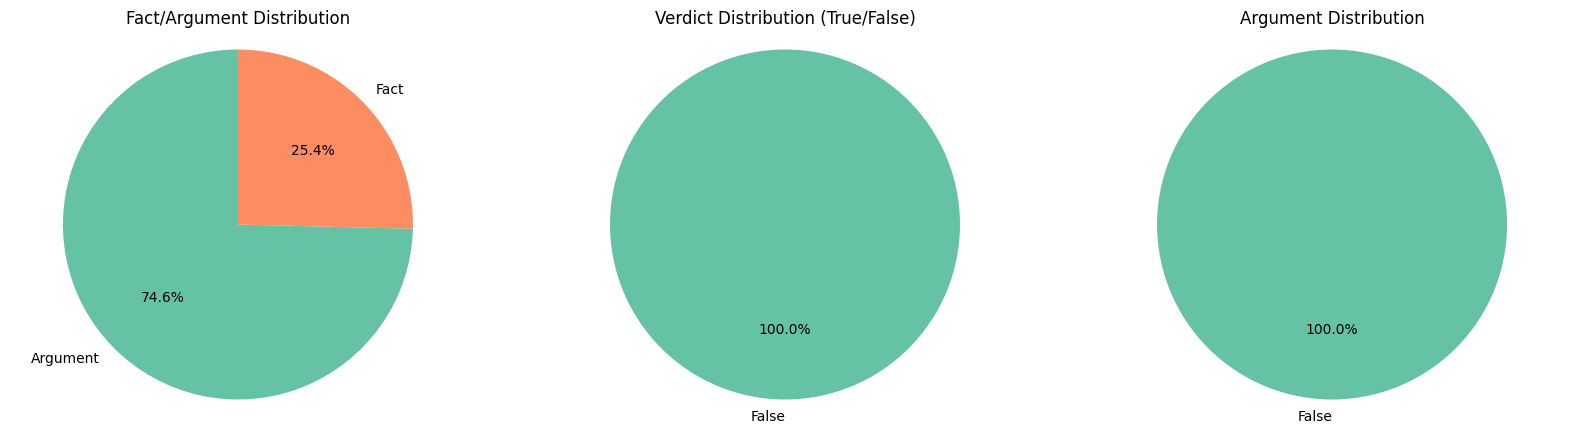

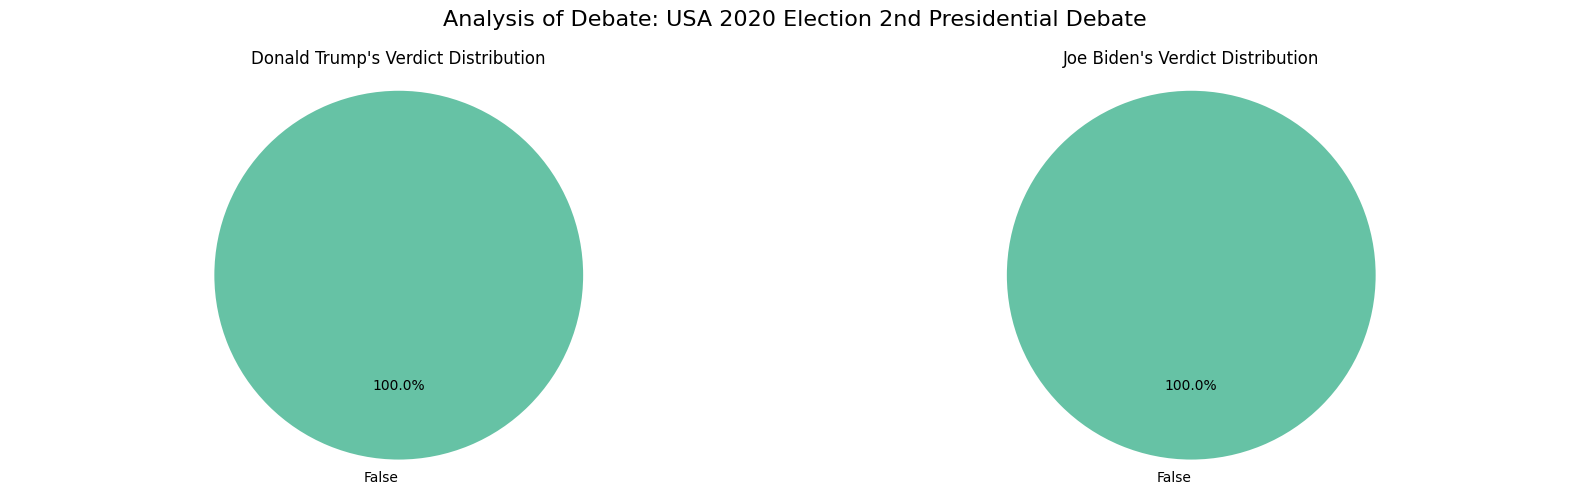

🗣️ Analyzing the debate dataset: USA 2020 Town Hall Trump Debate

🟥 Speaker with the most False statements: Savannah Guthrie
⚠️ No 'True' statements found in the facts dataset.

📊 Confidence Statistics:
   - Fact/Argument Dataset: Median Confidence = 0.56, Mean Confidence = 0.60
   - Fact Dataset: Median Confidence = 0.55, Mean Confidence = 0.60
   - Argument Dataset: Median Confidence = 0.94, Mean Confidence = 0.87

📊 Displaying the analysis plot for the debate: USA 2020 Town Hall Trump Debate...


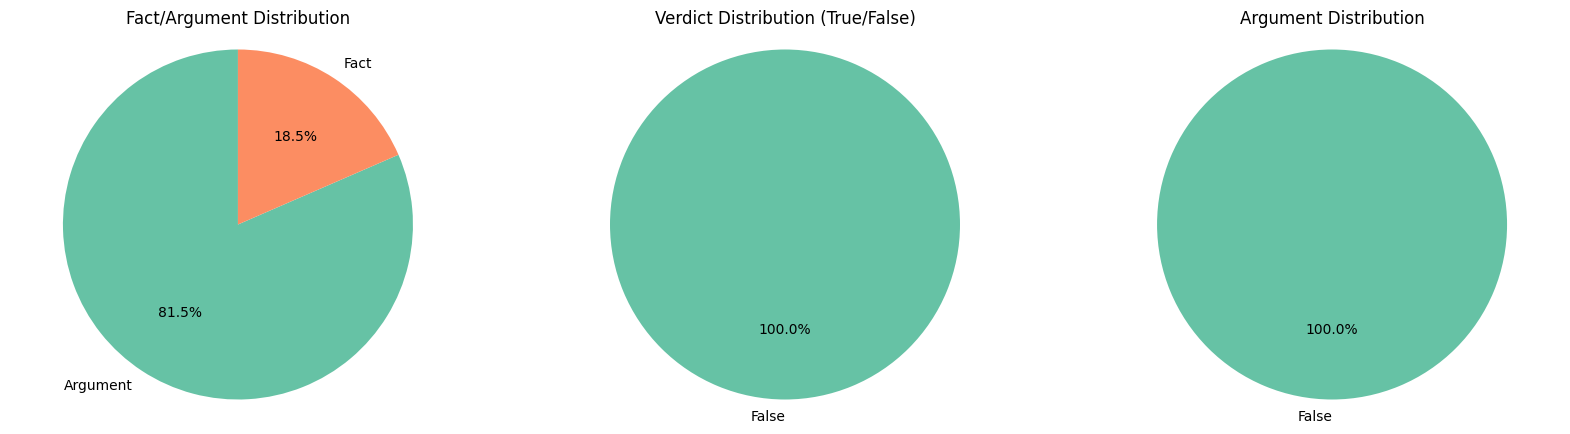

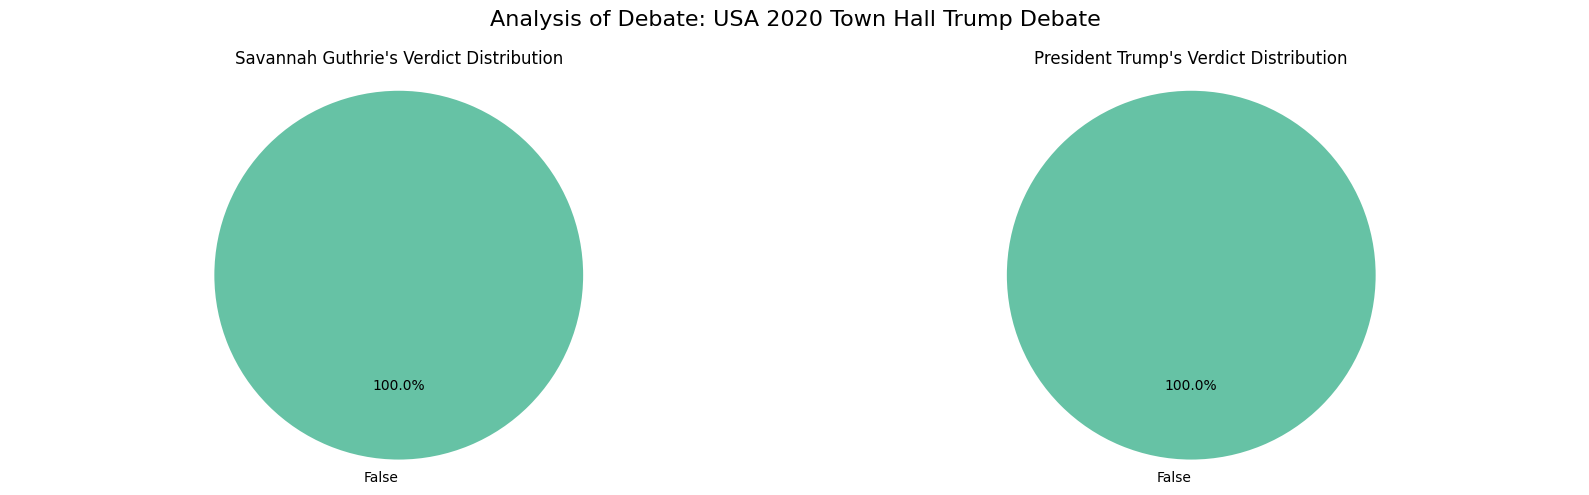

🗣️ Analyzing the debate dataset: USA 2020 Town Hall Biden Debate

🟥 Speaker with the most False statements: Savannah Guthrie
⚠️ No 'True' statements found in the facts dataset.

📊 Confidence Statistics:
   - Fact/Argument Dataset: Median Confidence = 0.56, Mean Confidence = 0.60
   - Fact Dataset: Median Confidence = 0.55, Mean Confidence = 0.60
   - Argument Dataset: Median Confidence = 0.94, Mean Confidence = 0.87

📊 Displaying the analysis plot for the debate: USA 2020 Town Hall Biden Debate...


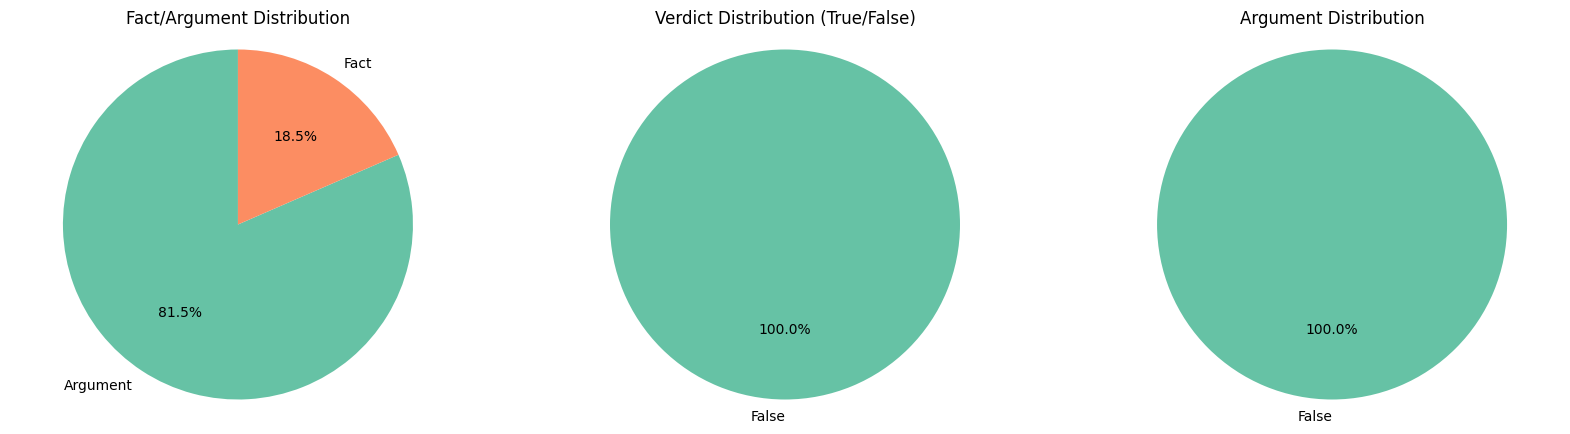

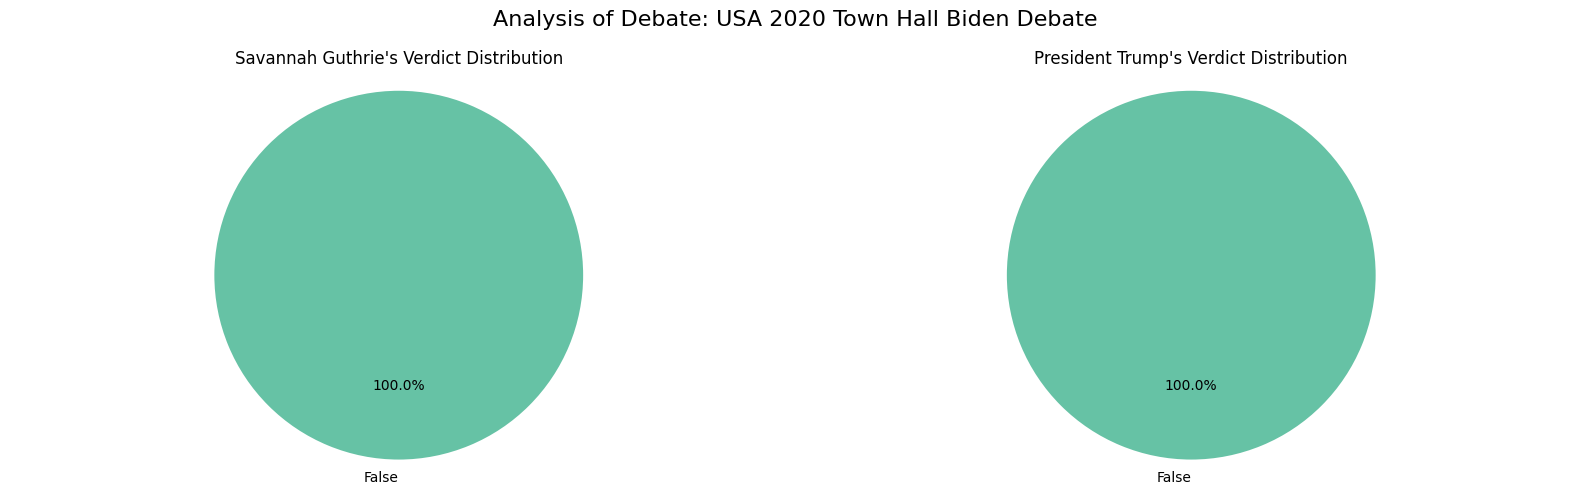

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

def datasets_analyse(df_fact_agrument: pd.DataFrame, df_fact: pd.DataFrame, df_agrument: pd.DataFrame, debate_name: str):
    print(f"🗣️ Analyzing the debate dataset: {debate_name}\n")
    
    # Group by speaker and verdict (True/False) for fact analysis
    speaker_counts = df_fact.groupby(['speaker', 'label']).size().unstack(fill_value=0)
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    #---------------Fact/Agrument distribution---------------
    fact_agrument_counts = df_fact_agrument['label'].value_counts()
    axs[0].pie(fact_agrument_counts, labels=fact_agrument_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(fact_agrument_counts)))
    axs[0].set_title("Fact/Argument Distribution")
    axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    #---------------False/True distribution---------------
    false_true_counts = df_fact['label'].value_counts()
    axs[1].pie(false_true_counts, labels=false_true_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(false_true_counts)))
    axs[1].set_title("Verdict Distribution (True/False)")
    axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    #---------------Argument distribution---------------
    agrument_label_counts = df_fact['label'].value_counts()
    axs[2].pie(agrument_label_counts, labels=agrument_label_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(agrument_label_counts)))
    axs[2].set_title("Argument Distribution")
    axs[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    #---------False/True distribution per speaker---------
    fig_1, axs_1 = plt.subplots(1, len(df_fact['speaker'].unique()), figsize=(16, 5))
    for i, speaker in enumerate(df_fact['speaker'].unique()):
        speaker_data = df_fact[df_fact['speaker'] == speaker]['label'].value_counts()
        
        axs_1[i].pie(speaker_data, labels=speaker_data.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(speaker_data)))
        axs_1[i].set_title(f"{speaker}'s Verdict Distribution")
        axs_1[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Find speaker with most False and most True statements
    if 'False' in speaker_counts.columns:
        most_false_speaker = speaker_counts['False'].idxmax()
        print(f"🟥 Speaker with the most False statements: {most_false_speaker}")
    else:
        print("⚠️ No 'False' statements found in the facts dataset.")
    
    if 'True' in speaker_counts.columns:
        most_true_speaker = speaker_counts['True'].idxmax()
        print(f"🟩 Speaker with the most True statements: {most_true_speaker}")
    else:
        print("⚠️ No 'True' statements found in the facts dataset.")

    # Median and Average confidence for each dataset
    print("\n📊 Confidence Statistics:")
    fact_agrument_confidence = df_fact_agrument["confidence"]
    fact_confidence = df_fact["confidence"]
    agrument_confidence = df_agrument["confidence"]

    print(f"   - Fact/Argument Dataset: Median Confidence = {fact_agrument_confidence.median():.2f}, Mean Confidence = {fact_agrument_confidence.mean():.2f}")
    print(f"   - Fact Dataset: Median Confidence = {fact_confidence.median():.2f}, Mean Confidence = {fact_confidence.mean():.2f}")
    print(f"   - Argument Dataset: Median Confidence = {agrument_confidence.median():.2f}, Mean Confidence = {agrument_confidence.mean():.2f}")

    print(f"\n📊 Displaying the analysis plot for the debate: {debate_name}...")
    plt.suptitle(f"Analysis of Debate: {debate_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

datasets_analyse(second_presidential_fact_agrument, second_presidential_fact, second_presidential_agrument, "USA 2020 Election 2nd Presidential Debate")
datasets_analyse(trump_town_hall_fact_agrument, trump_town_hall_fact, trump_town_hall_agrument, "USA 2020 Town Hall Trump Debate")
datasets_analyse(trump_town_hall_fact_agrument, trump_town_hall_fact, trump_town_hall_agrument, "USA 2020 Town Hall Biden Debate")